<a href="https://colab.research.google.com/github/UdayShankar8/TSAI--S6/blob/master/EVA4_S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Team :
krishnateja.k2@gmail.com
amar.r.naik@gmail.com
shankar.uday007@gmail.com
prasad.shripathi@gmail.com

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)), 
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                      #  transforms.RandomErasing()
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

469
79
torch.Size([128, 1, 28, 28])
torch.Size([128])


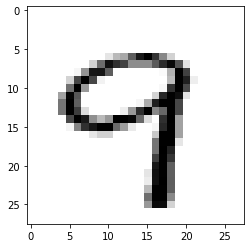

In [0]:
# # We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(sum(1 for _ in train_loader))
print(sum(1 for _ in test_loader))
print(images.shape)
print(labels.shape)

# # Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [0]:
# figure = plt.figure()
# num_of_images = 60
# for index in range(1, num_of_images + 1):
#     plt.subplot(6, 10, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [0]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The model
Let's start with the model we first saw

In [0]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
         # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) # output_size = 26, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # output_size = 24, RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) 
        # output_size = 11, RF = 6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 12, RF = 6

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value),
            nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # output_size = 10, RF = 10

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # output_size = 10, RF = 14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1,bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # output_size = 10, RF = 16

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # output_size = 10, RF = 18
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 10, RF = 22

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1, RF = 34


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
           Dropout-3           [-1, 10, 26, 26]               0
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
       BatchNorm2d-6           [-1, 20, 24, 24]              40
           Dropout-7           [-1, 20, 24, 24]               0
              ReLU-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]           1,080
      BatchNorm2d-12           [-1, 12, 10, 10]              24
          Dropout-13           [-1, 12, 10, 10]               0
             ReLU-14           [-1

In [0]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

convblock1.0.weight 	 torch.Size([10, 1, 3, 3])
convblock1.1.weight 	 torch.Size([10])
convblock1.1.bias 	 torch.Size([10])
convblock1.1.running_mean 	 torch.Size([10])
convblock1.1.running_var 	 torch.Size([10])
convblock1.1.num_batches_tracked 	 torch.Size([])
convblock2.0.weight 	 torch.Size([20, 10, 3, 3])
convblock2.1.weight 	 torch.Size([20])
convblock2.1.bias 	 torch.Size([20])
convblock2.1.running_mean 	 torch.Size([20])
convblock2.1.running_var 	 torch.Size([20])
convblock2.1.num_batches_tracked 	 torch.Size([])
convblock3.0.weight 	 torch.Size([10, 20, 1, 1])
convblock4.0.weight 	 torch.Size([12, 10, 3, 3])
convblock4.1.weight 	 torch.Size([12])
convblock4.1.bias 	 torch.Size([12])
convblock4.1.running_mean 	 torch.Size([12])
convblock4.1.running_var 	 torch.Size([12])
convblock4.1.num_batches_tracked 	 torch.Size([])
convblock5.0.weight 	 torch.Size([16, 12, 3, 3])
convblock5.1.weight 	 torch.Size([16])
convblock5.1.bias 	 torch.Size([16])
convblock5.1.running_mean 	 torch.S

In [0]:
l = [module for module in model.modules() if type(module) != nn.Sequential]
print(l[1])

Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)


# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

train_losses_l1 = []
test_losses_l1 = []
train_acc_l1 = []
test_acc_l1 = []

train_losses_l2 = []
test_losses_l2 = []
train_acc_l2 = []
test_acc_l2 = []

train_losses_l1_l2 = []
test_losses_l1_l2 = []
train_acc_l1_l2 = []
test_acc_l1_l2 = []

def train(model, device, train_loader, optimizer, epoch, loss_type):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  count = 0
  if epoch >=39:
    figure = plt.figure(figsize=(15,10))
    figure.suptitle('Training Data : Misclassification', fontsize=16)
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    if loss_type == 'Normal':
      train_losses.append(loss)
    elif loss_type == 'L1':
      # l1_crit =  nn.L1Loss(size_average=False,reduction='sum')
      reg_loss = 0
      for param in model.parameters():
        reg_loss += torch.sum(abs(param))
      factor = 0.0005
      loss += factor * reg_loss 
      train_losses_l1.append(loss)
    elif loss_type == 'L2':
      train_losses_l2.append(loss) 
    elif loss_type == 'ElastiNet':
      # l1_crit = nn.L1Loss(size_average=False,reduction='sum')
      reg_loss = 0
      for param in model.parameters():
        reg_loss += torch.sum(abs(param)) #l1_crit(param).item()
      factor = 0.0005
      loss += factor * reg_loss 
      train_losses_l1_l2.append(loss) 

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    x = torch.tensor((~pred.eq(target.view_as(pred))), dtype=torch.float, device = device)
    
    for index,image in enumerate(data):      
        if x[index] == 1 and count < 25 and epoch>=39:
          plt.subplot(5, 5, count+1)
          plt.axis('off')
          plt.title("Classified as : "+ str(pred[index].item())+"\n Label : "+ str(target.view_as(pred)[index].item()))
          plt.imshow(data[index].cpu().numpy().squeeze(), cmap='gray_r')
          count = count+1        

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    if loss_type == 'Normal':
      train_acc.append(100*correct/processed)
    elif loss_type == 'L1':
      train_acc_l1.append(100*correct/processed)
    elif loss_type == 'L2':
      train_acc_l2.append(100*correct/processed)
    elif loss_type == 'ElastiNet':
      train_acc_l1_l2.append(100*correct/processed)

def test(model, device, test_loader,loss_type):
    model.eval()
    test_loss = 0
    correct = 0
    count = 0
    if epoch >=39:
      figure = plt.figure(figsize=(15,10))
      figure.suptitle('Test Data : Misclassification', fontsize=16)

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            x = torch.tensor((~pred.eq(target.view_as(pred))), dtype=torch.float, device = device)
    
            for index,image in enumerate(data):      
                if x[index] == 1 and count < 25 and epoch>=39:
                  plt.subplot(5, 5, count+1)
                  plt.axis('off')
                  plt.title("Classified as : "+ str(pred[index].item())+"\n Label : "+ str(target.view_as(pred)[index].item()))
                  plt.imshow(data[index].cpu().numpy().squeeze(), cmap='gray_r')
                  count = count+1   

    test_loss /= len(test_loader.dataset)

    if loss_type == 'Normal':
      test_losses.append(test_loss)
    elif loss_type == 'L1':
      test_losses_l1.append(test_loss)
    elif loss_type == 'L2':
      test_losses_l2.append(test_loss)
    elif loss_type == 'ElastiNet':
      test_losses_l1_l2.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    if loss_type == 'Normal':
      test_acc.append(100. * correct / len(test_loader.dataset))
    elif loss_type == 'L1':
      test_acc_l1.append(100. * correct / len(test_loader.dataset))
    elif loss_type == 'L2':
      test_acc_l2.append(100. * correct / len(test_loader.dataset))
    elif loss_type == 'ElastiNet':
      test_acc_l1_l2.append(100. * correct / len(test_loader.dataset))

    

# Let's Train and test our model

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Loss=0.044544342905282974 Batch_id=468 Accuracy=89.83: 100%|██████████| 469/469 [00:15<00:00, 30.50it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0712, Accuracy: 9789/10000 (97.89%)

EPOCH: 1


Loss=0.0980742946267128 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:15<00:00, 30.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0637, Accuracy: 9798/10000 (97.98%)

EPOCH: 2


Loss=0.05612707510590553 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:15<00:00, 36.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Accuracy: 9869/10000 (98.69%)

EPOCH: 3


Loss=0.06909671425819397 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:15<00:00, 30.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9863/10000 (98.63%)

EPOCH: 4


Loss=0.07105621695518494 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:15<00:00, 30.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Accuracy: 9888/10000 (98.88%)

EPOCH: 5


Loss=0.05810675024986267 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:15<00:00, 30.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0399, Accuracy: 9871/10000 (98.71%)

EPOCH: 6


Loss=0.008079320192337036 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:15<00:00, 29.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9893/10000 (98.93%)

EPOCH: 7


Loss=0.018024390563368797 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:15<00:00, 29.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9883/10000 (98.83%)

EPOCH: 8


Loss=0.034967243671417236 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:15<00:00, 30.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9886/10000 (98.86%)

EPOCH: 9


Loss=0.003821681020781398 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:15<00:00, 29.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9918/10000 (99.18%)

EPOCH: 10


Loss=0.006326904054731131 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:15<00:00, 29.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


Loss=0.06630923599004745 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:15<00:00, 29.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.013862143270671368 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:15<00:00, 29.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9913/10000 (99.13%)

EPOCH: 13


Loss=0.05568744242191315 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:16<00:00, 28.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9920/10000 (99.20%)

EPOCH: 14


Loss=0.029248768463730812 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:15<00:00, 37.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9918/10000 (99.18%)

EPOCH: 15


Loss=0.031659748405218124 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:15<00:00, 29.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9929/10000 (99.29%)

EPOCH: 16


Loss=0.01682506501674652 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:15<00:00, 29.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9917/10000 (99.17%)

EPOCH: 17


Loss=0.023208782076835632 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:15<00:00, 30.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9919/10000 (99.19%)

EPOCH: 18


Loss=0.06280267983675003 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 30.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9925/10000 (99.25%)

EPOCH: 19


Loss=0.005804975982755423 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:15<00:00, 29.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9925/10000 (99.25%)

EPOCH: 20


Loss=0.02860996685922146 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9936/10000 (99.36%)

EPOCH: 21


Loss=0.06123913452029228 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 30.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9932/10000 (99.32%)

EPOCH: 22


Loss=0.012167558073997498 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:15<00:00, 37.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9928/10000 (99.28%)

EPOCH: 23


Loss=0.11021015793085098 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 29.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9927/10000 (99.27%)

EPOCH: 24


Loss=0.004770701285451651 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 29.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9906/10000 (99.06%)

EPOCH: 25


Loss=0.03815941512584686 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 29.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9922/10000 (99.22%)

EPOCH: 26


Loss=0.005178029183298349 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 30.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9930/10000 (99.30%)

EPOCH: 27


Loss=0.033685579895973206 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 30.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9943/10000 (99.43%)

EPOCH: 28


Loss=0.0508611798286438 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:15<00:00, 30.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9926/10000 (99.26%)

EPOCH: 29


Loss=0.028516681864857674 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 38.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9937/10000 (99.37%)

EPOCH: 30


Loss=0.028963929042220116 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 29.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9934/10000 (99.34%)

EPOCH: 31


Loss=0.011563926935195923 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:15<00:00, 30.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9926/10000 (99.26%)

EPOCH: 32


Loss=0.03754168748855591 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 30.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9943/10000 (99.43%)

EPOCH: 33


Loss=0.03331683948636055 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 29.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9943/10000 (99.43%)

EPOCH: 34


Loss=0.014743576757609844 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 30.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9931/10000 (99.31%)

EPOCH: 35


Loss=0.05976803973317146 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 37.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9924/10000 (99.24%)

EPOCH: 36


Loss=0.015804031863808632 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 30.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.39%)

EPOCH: 37


Loss=0.06113550066947937 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:15<00:00, 38.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9939/10000 (99.39%)

EPOCH: 38


Loss=0.035435620695352554 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 31.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9943/10000 (99.43%)

EPOCH: 39


Loss=0.0006661713123321533 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 38.19it/s]



Test set: Average loss: 0.0205, Accuracy: 9931/10000 (99.31%)



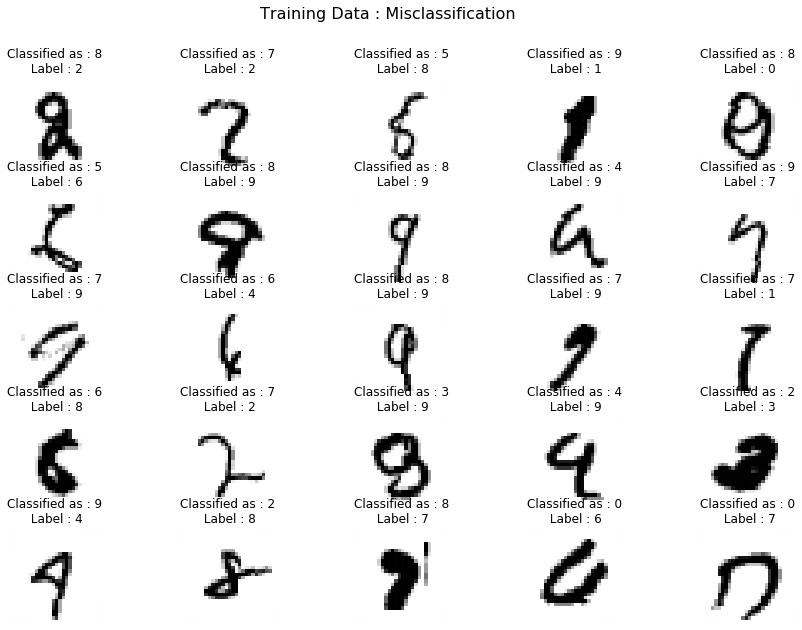

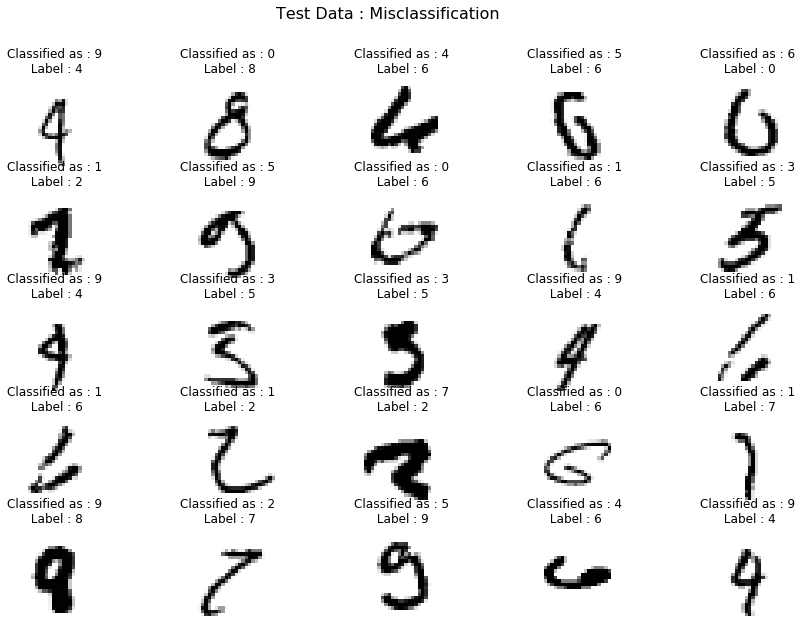

In [0]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,)
# scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,'Normal')
    # scheduler.step()
    test(model, device, test_loader,'Normal')

Text(0.5, 1.0, 'Test Accuracy')

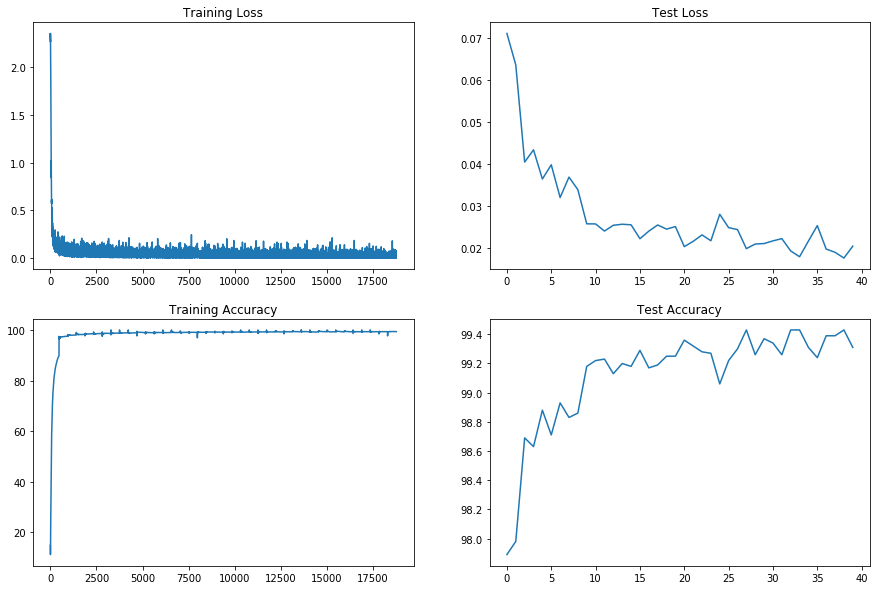

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Loss=0.371562123298645 Batch_id=468 Accuracy=90.42: 100%|██████████| 469/469 [00:16<00:00, 29.20it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0695, Accuracy: 9797/10000 (97.97%)

EPOCH: 1


Loss=0.29469379782676697 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:15<00:00, 29.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0684, Accuracy: 9785/10000 (97.85%)

EPOCH: 2


Loss=0.28310006856918335 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:16<00:00, 29.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0638, Accuracy: 9807/10000 (98.07%)

EPOCH: 3


Loss=0.17190594971179962 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:16<00:00, 28.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0691, Accuracy: 9783/10000 (97.83%)

EPOCH: 4


Loss=0.25510162115097046 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:16<00:00, 28.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9845/10000 (98.45%)

EPOCH: 5


Loss=0.22463321685791016 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:15<00:00, 37.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0572, Accuracy: 9832/10000 (98.32%)

EPOCH: 6


Loss=0.20517607033252716 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:16<00:00, 28.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0564, Accuracy: 9832/10000 (98.32%)

EPOCH: 7


Loss=0.1932796984910965 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:16<00:00, 28.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0537, Accuracy: 9831/10000 (98.31%)

EPOCH: 8


Loss=0.1804894655942917 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9885/10000 (98.85%)

EPOCH: 9


Loss=0.2321668565273285 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:16<00:00, 29.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9902/10000 (99.02%)

EPOCH: 10


Loss=0.21892565488815308 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:16<00:00, 28.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 9869/10000 (98.69%)

EPOCH: 11


Loss=0.19856509566307068 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:16<00:00, 36.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9890/10000 (98.90%)

EPOCH: 12


Loss=0.22914361953735352 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:16<00:00, 28.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9886/10000 (98.86%)

EPOCH: 13


Loss=0.18082115054130554 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:16<00:00, 29.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0725, Accuracy: 9773/10000 (97.73%)

EPOCH: 14


Loss=0.18559011816978455 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9883/10000 (98.83%)

EPOCH: 15


Loss=0.24932345747947693 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:16<00:00, 29.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0546, Accuracy: 9829/10000 (98.29%)

EPOCH: 16


Loss=0.17166860401630402 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:16<00:00, 36.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0399, Accuracy: 9872/10000 (98.72%)

EPOCH: 17


Loss=0.18522988259792328 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:16<00:00, 28.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9886/10000 (98.86%)

EPOCH: 18


Loss=0.1495169997215271 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:16<00:00, 29.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9910/10000 (99.10%)

EPOCH: 19


Loss=0.1528245359659195 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:16<00:00, 28.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9892/10000 (98.92%)

EPOCH: 20


Loss=0.20490267872810364 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:16<00:00, 29.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0650, Accuracy: 9793/10000 (97.93%)

EPOCH: 21


Loss=0.1880112588405609 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:16<00:00, 29.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Accuracy: 9866/10000 (98.66%)

EPOCH: 22


Loss=0.23365476727485657 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:16<00:00, 29.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0511, Accuracy: 9831/10000 (98.31%)

EPOCH: 23


Loss=0.20384931564331055 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:15<00:00, 34.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9912/10000 (99.12%)

EPOCH: 24


Loss=0.14027385413646698 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:15<00:00, 29.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9855/10000 (98.55%)

EPOCH: 25


Loss=0.17243434488773346 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:15<00:00, 29.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 9893/10000 (98.93%)

EPOCH: 26


Loss=0.20714610815048218 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:16<00:00, 29.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Accuracy: 9891/10000 (98.91%)

EPOCH: 27


Loss=0.15182889997959137 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:15<00:00, 29.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Accuracy: 9867/10000 (98.67%)

EPOCH: 28


Loss=0.15348699688911438 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:15<00:00, 29.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9908/10000 (99.08%)

EPOCH: 29


Loss=0.1446649134159088 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:15<00:00, 29.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0454, Accuracy: 9859/10000 (98.59%)

EPOCH: 30


Loss=0.15021009743213654 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:16<00:00, 29.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0460, Accuracy: 9846/10000 (98.46%)

EPOCH: 31


Loss=0.1534920632839203 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:15<00:00, 29.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0714, Accuracy: 9786/10000 (97.86%)

EPOCH: 32


Loss=0.16754549741744995 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:15<00:00, 29.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9906/10000 (99.06%)

EPOCH: 33


Loss=0.20781871676445007 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:15<00:00, 30.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9878/10000 (98.78%)

EPOCH: 34


Loss=0.1447991281747818 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0678, Accuracy: 9779/10000 (97.79%)

EPOCH: 35


Loss=0.12210722267627716 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:15<00:00, 29.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9880/10000 (98.80%)

EPOCH: 36


Loss=0.13851162791252136 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:15<00:00, 36.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9912/10000 (99.12%)

EPOCH: 37


Loss=0.14744794368743896 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:15<00:00, 29.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9866/10000 (98.66%)

EPOCH: 38


Loss=0.13451576232910156 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:15<00:00, 29.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9888/10000 (98.88%)

EPOCH: 39


Loss=0.17484353482723236 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:16<00:00, 37.49it/s]



Test set: Average loss: 0.0341, Accuracy: 9903/10000 (99.03%)



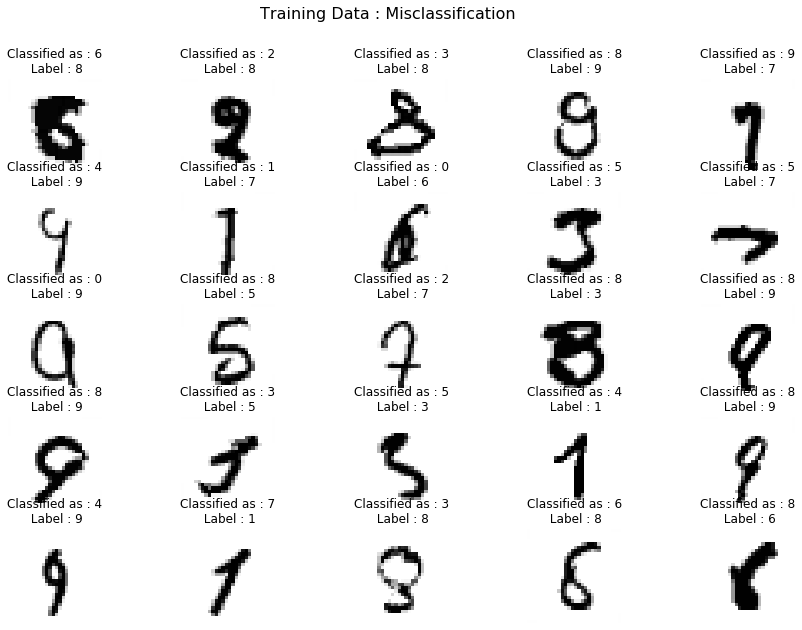

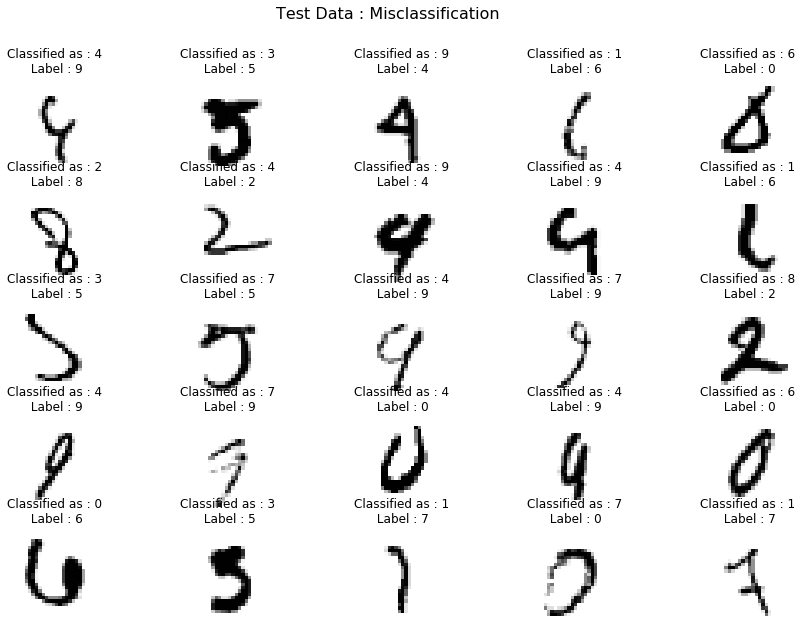

In [0]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
# scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,'L1')
    # scheduler.step()
    test(model, device, test_loader,'L1')

Text(0.5, 1.0, 'Test Accuracy')

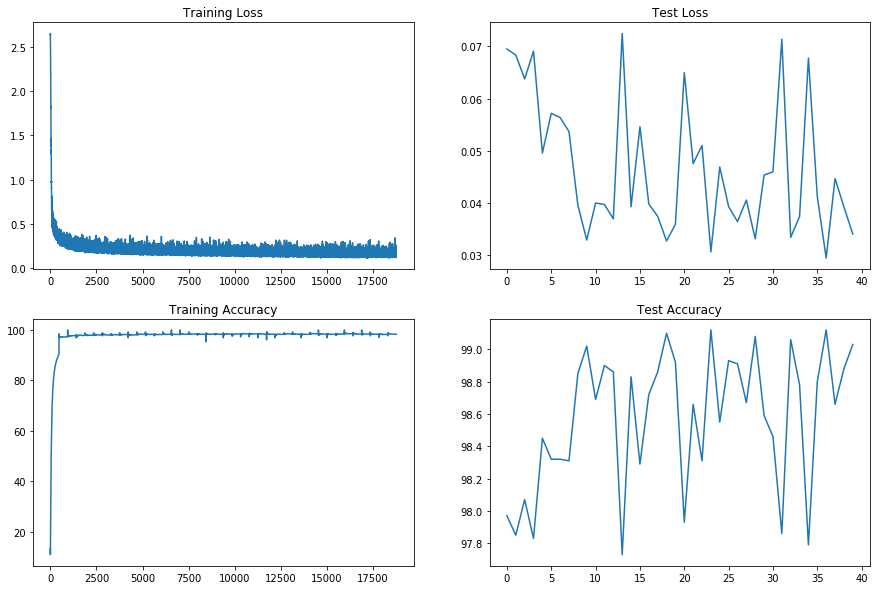

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_l1)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_l1)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses_l1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_l1)
axs[1, 1].set_title("Test Accuracy")

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Loss=0.13526912033557892 Batch_id=468 Accuracy=90.87: 100%|██████████| 469/469 [00:15<00:00, 30.95it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0901, Accuracy: 9744/10000 (97.44%)

EPOCH: 1


Loss=0.04898938164114952 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:14<00:00, 38.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0732, Accuracy: 9771/10000 (97.71%)

EPOCH: 2


Loss=0.045511845499277115 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:14<00:00, 36.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0575, Accuracy: 9814/10000 (98.14%)

EPOCH: 3


Loss=0.030809322372078896 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:14<00:00, 31.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0646, Accuracy: 9811/10000 (98.11%)

EPOCH: 4


Loss=0.06892912834882736 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:15<00:00, 30.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9882/10000 (98.82%)

EPOCH: 5


Loss=0.09161019325256348 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:14<00:00, 31.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 9873/10000 (98.73%)

EPOCH: 6


Loss=0.015973806381225586 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:14<00:00, 37.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9892/10000 (98.92%)

EPOCH: 7


Loss=0.023545512929558754 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:14<00:00, 39.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9913/10000 (99.13%)

EPOCH: 8


Loss=0.019900189712643623 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:14<00:00, 31.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9917/10000 (99.17%)

EPOCH: 9


Loss=0.03515162691473961 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:14<00:00, 31.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9912/10000 (99.12%)

EPOCH: 10


Loss=0.07512341439723969 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:15<00:00, 30.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9898/10000 (98.98%)

EPOCH: 11


Loss=0.030890563502907753 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:14<00:00, 31.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9926/10000 (99.26%)

EPOCH: 12


Loss=0.01780405081808567 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:14<00:00, 38.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9923/10000 (99.23%)

EPOCH: 13


Loss=0.06899696588516235 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:15<00:00, 30.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9912/10000 (99.12%)

EPOCH: 14


Loss=0.012712006457149982 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:15<00:00, 30.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9922/10000 (99.22%)

EPOCH: 15


Loss=0.03662298619747162 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 31.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9926/10000 (99.26%)

EPOCH: 16


Loss=0.02002584934234619 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:14<00:00, 39.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9923/10000 (99.23%)

EPOCH: 17


Loss=0.03646453097462654 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:14<00:00, 31.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9916/10000 (99.16%)

EPOCH: 18


Loss=0.03316037729382515 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:15<00:00, 31.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9923/10000 (99.23%)

EPOCH: 19


Loss=0.020173199474811554 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 31.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9932/10000 (99.32%)

EPOCH: 20


Loss=0.012928679585456848 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:14<00:00, 31.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9923/10000 (99.23%)

EPOCH: 21


Loss=0.012744799256324768 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9922/10000 (99.22%)

EPOCH: 22


Loss=0.008952985517680645 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:14<00:00, 31.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9910/10000 (99.10%)

EPOCH: 23


Loss=0.03580675646662712 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:14<00:00, 39.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9909/10000 (99.09%)

EPOCH: 24


Loss=0.010861258022487164 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 31.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9911/10000 (99.11%)

EPOCH: 25


Loss=0.004470606800168753 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 40.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9914/10000 (99.14%)

EPOCH: 26


Loss=0.009512941353023052 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:14<00:00, 31.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9923/10000 (99.23%)

EPOCH: 27


Loss=0.02570558898150921 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:15<00:00, 30.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9924/10000 (99.24%)

EPOCH: 28


Loss=0.040709223598241806 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:14<00:00, 31.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9928/10000 (99.28%)

EPOCH: 29


Loss=0.04710164666175842 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:14<00:00, 31.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9914/10000 (99.14%)

EPOCH: 30


Loss=0.08871599286794662 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:14<00:00, 31.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9934/10000 (99.34%)

EPOCH: 31


Loss=0.0094279944896698 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:14<00:00, 31.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9920/10000 (99.20%)

EPOCH: 32


Loss=0.02864019013941288 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:15<00:00, 37.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9917/10000 (99.17%)

EPOCH: 33


Loss=0.04196068271994591 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 31.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9922/10000 (99.22%)

EPOCH: 34


Loss=0.02436966262757778 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 31.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9916/10000 (99.16%)

EPOCH: 35


Loss=0.02680634893476963 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:14<00:00, 31.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9921/10000 (99.21%)

EPOCH: 36


Loss=0.033712130039930344 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:14<00:00, 31.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9936/10000 (99.36%)

EPOCH: 37


Loss=0.03521840646862984 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 31.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9913/10000 (99.13%)

EPOCH: 38


Loss=0.012241989374160767 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:14<00:00, 39.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9928/10000 (99.28%)

EPOCH: 39


Loss=0.004882127046585083 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:15<00:00, 31.14it/s]



Test set: Average loss: 0.0220, Accuracy: 9934/10000 (99.34%)



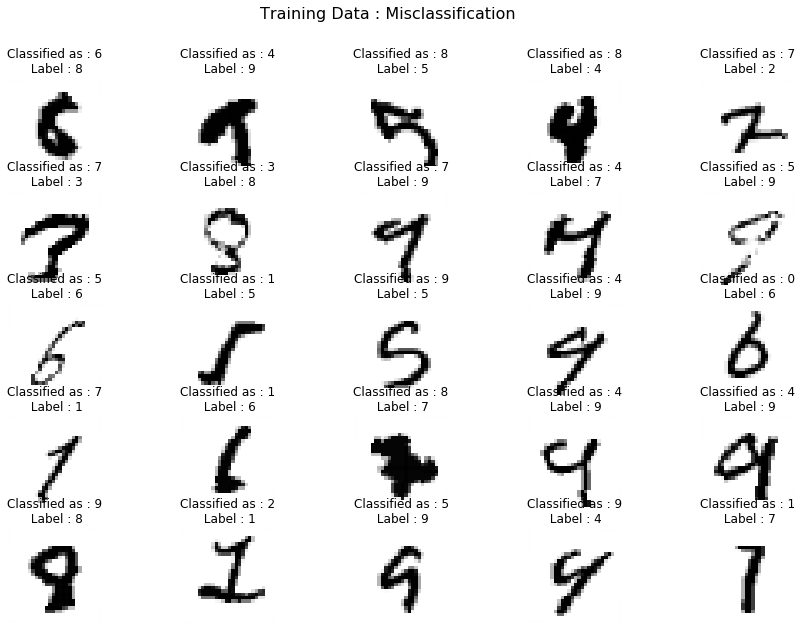

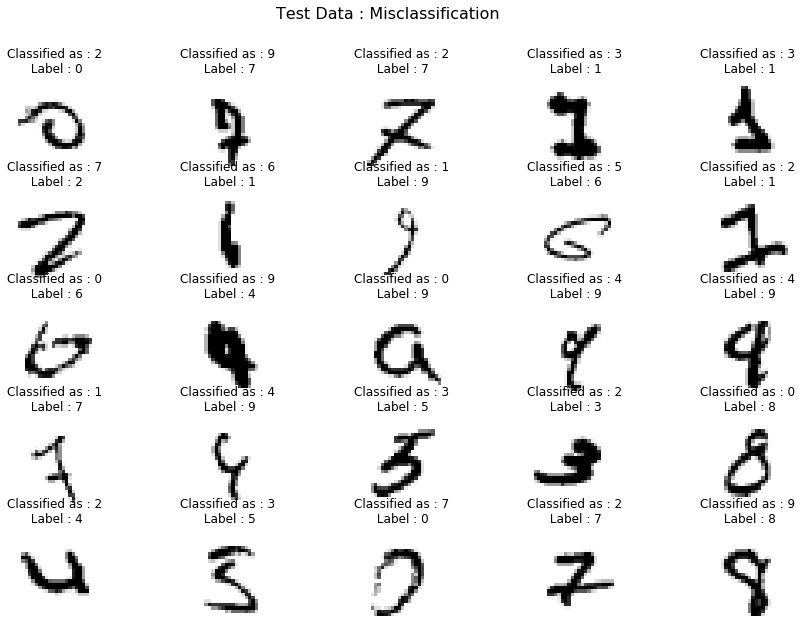

In [0]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay=0.001)
# scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,'L2')
    # scheduler.step()
    test(model, device, test_loader,'L2')

Text(0.5, 1.0, 'Test Accuracy')

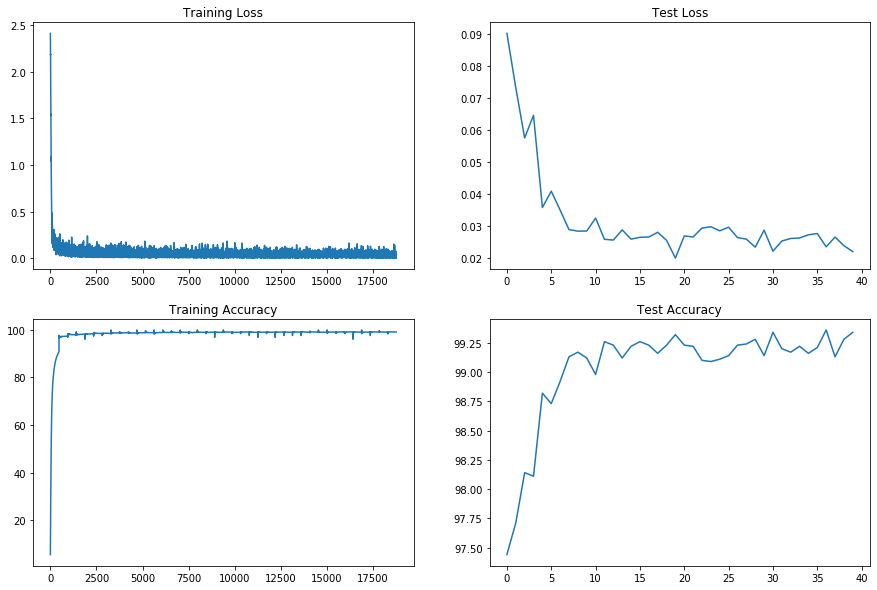

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_l2)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_l2)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses_l2)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_l2)
axs[1, 1].set_title("Test Accuracy")

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Loss=0.39633411169052124 Batch_id=468 Accuracy=89.91: 100%|██████████| 469/469 [00:15<00:00, 30.09it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0813, Accuracy: 9789/10000 (97.89%)

EPOCH: 1


Loss=0.2170431911945343 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:15<00:00, 29.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0512, Accuracy: 9842/10000 (98.42%)

EPOCH: 2


Loss=0.20623968541622162 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:15<00:00, 32.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0671, Accuracy: 9789/10000 (97.89%)

EPOCH: 3


Loss=0.233117938041687 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:15<00:00, 29.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0605, Accuracy: 9824/10000 (98.24%)

EPOCH: 4


Loss=0.3210434317588806 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9851/10000 (98.51%)

EPOCH: 5


Loss=0.1801297664642334 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:15<00:00, 30.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 9857/10000 (98.57%)

EPOCH: 6


Loss=0.21411028504371643 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:15<00:00, 29.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0483, Accuracy: 9846/10000 (98.46%)

EPOCH: 7


Loss=0.1771031618118286 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:15<00:00, 37.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9867/10000 (98.67%)

EPOCH: 8


Loss=0.18191517889499664 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:15<00:00, 30.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 9862/10000 (98.62%)

EPOCH: 9


Loss=0.14822669327259064 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:15<00:00, 30.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9862/10000 (98.62%)

EPOCH: 10


Loss=0.19932009279727936 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:15<00:00, 29.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0664, Accuracy: 9795/10000 (97.95%)

EPOCH: 11


Loss=0.14568769931793213 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:15<00:00, 30.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0706, Accuracy: 9787/10000 (97.87%)

EPOCH: 12


Loss=0.21257540583610535 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:15<00:00, 30.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0641, Accuracy: 9807/10000 (98.07%)

EPOCH: 13


Loss=0.16098758578300476 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:15<00:00, 29.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0546, Accuracy: 9843/10000 (98.43%)

EPOCH: 14


Loss=0.16044287383556366 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:15<00:00, 30.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0488, Accuracy: 9870/10000 (98.70%)

EPOCH: 15


Loss=0.16988617181777954 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:15<00:00, 29.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9876/10000 (98.76%)

EPOCH: 16


Loss=0.18390175700187683 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:15<00:00, 29.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9883/10000 (98.83%)

EPOCH: 17


Loss=0.15549133718013763 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:15<00:00, 30.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0579, Accuracy: 9825/10000 (98.25%)

EPOCH: 18


Loss=0.15556059777736664 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:15<00:00, 30.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9894/10000 (98.94%)

EPOCH: 19


Loss=0.11155441403388977 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:15<00:00, 30.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9872/10000 (98.72%)

EPOCH: 20


Loss=0.17895111441612244 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:15<00:00, 30.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9855/10000 (98.55%)

EPOCH: 21


Loss=0.164753258228302 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:15<00:00, 30.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Accuracy: 9870/10000 (98.70%)

EPOCH: 22


Loss=0.12732043862342834 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:15<00:00, 30.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0636, Accuracy: 9809/10000 (98.09%)

EPOCH: 23


Loss=0.14206258952617645 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:15<00:00, 30.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0521, Accuracy: 9843/10000 (98.43%)

EPOCH: 24


Loss=0.12407940626144409 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:15<00:00, 37.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9859/10000 (98.59%)

EPOCH: 25


Loss=0.13562943041324615 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:15<00:00, 29.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9890/10000 (98.90%)

EPOCH: 26


Loss=0.12261098623275757 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:15<00:00, 30.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0535, Accuracy: 9844/10000 (98.44%)

EPOCH: 27


Loss=0.1689486801624298 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0694, Accuracy: 9791/10000 (97.91%)

EPOCH: 28


Loss=0.11906705051660538 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:15<00:00, 29.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9902/10000 (99.02%)

EPOCH: 29


Loss=0.17087998986244202 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:15<00:00, 29.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9875/10000 (98.75%)

EPOCH: 30


Loss=0.17938494682312012 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:15<00:00, 29.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 9866/10000 (98.66%)

EPOCH: 31


Loss=0.12189463526010513 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:15<00:00, 30.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Accuracy: 9873/10000 (98.73%)

EPOCH: 32


Loss=0.14124634861946106 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9863/10000 (98.63%)

EPOCH: 33


Loss=0.17919832468032837 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:15<00:00, 37.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9888/10000 (98.88%)

EPOCH: 34


Loss=0.17260825634002686 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:15<00:00, 30.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0548, Accuracy: 9839/10000 (98.39%)

EPOCH: 35


Loss=0.12421855330467224 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:15<00:00, 30.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0525, Accuracy: 9852/10000 (98.52%)

EPOCH: 36


Loss=0.177774578332901 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:15<00:00, 37.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9852/10000 (98.52%)

EPOCH: 37


Loss=0.13939781486988068 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:15<00:00, 30.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9887/10000 (98.87%)

EPOCH: 38


Loss=0.12934944033622742 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:15<00:00, 30.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Accuracy: 9866/10000 (98.66%)

EPOCH: 39


Loss=0.29053783416748047 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:16<00:00, 29.00it/s]



Test set: Average loss: 0.0541, Accuracy: 9850/10000 (98.50%)



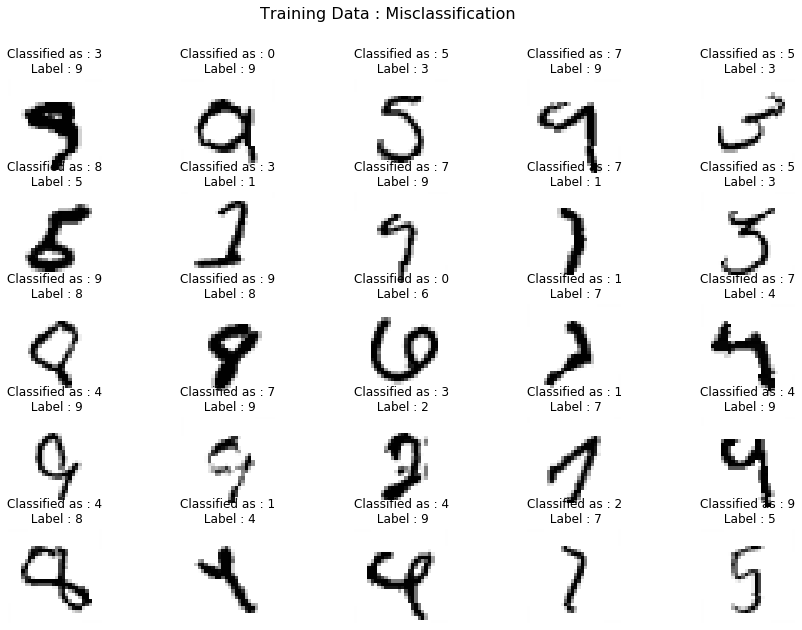

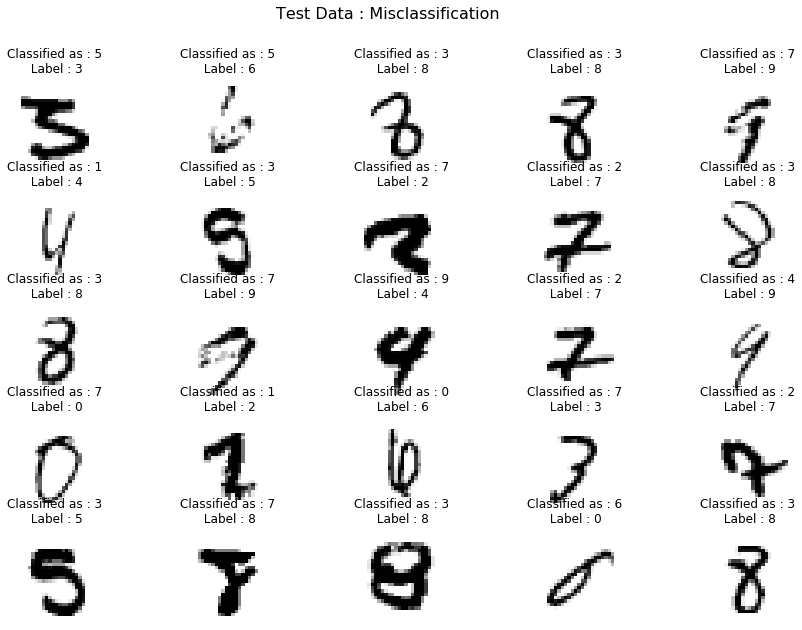

In [0]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay=0.001)
# scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,'ElastiNet')
    # scheduler.step()
    test(model, device, test_loader,'ElastiNet')

Text(0.5, 1.0, 'Test Accuracy')

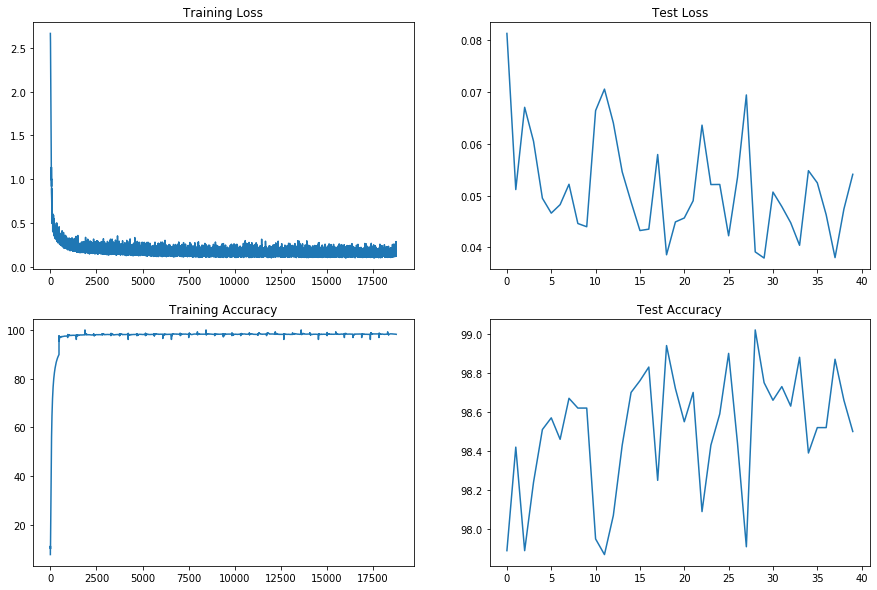

In [0]:

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_l1_l2)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_l1_l2)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses_l1_l2)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_l1_l2)
axs[1, 1].set_title("Test Accuracy")

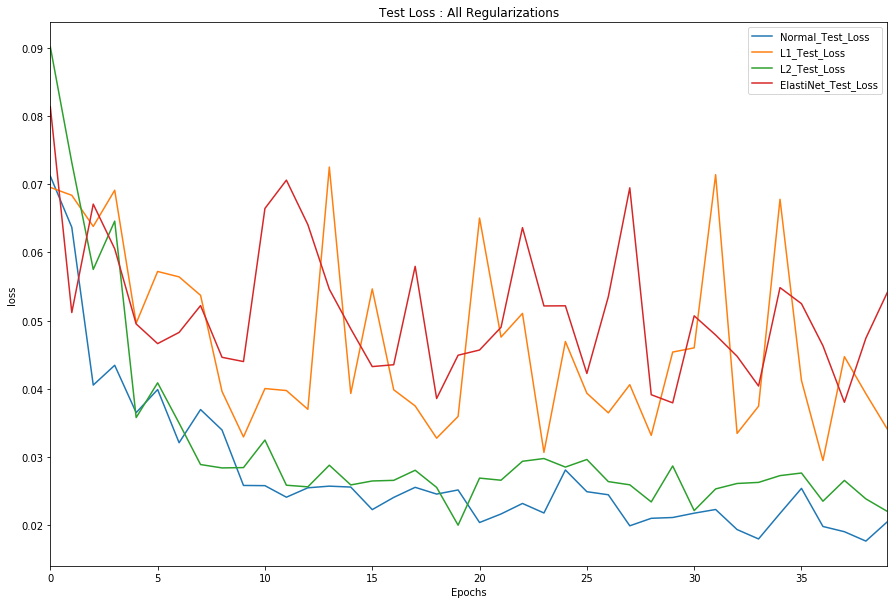

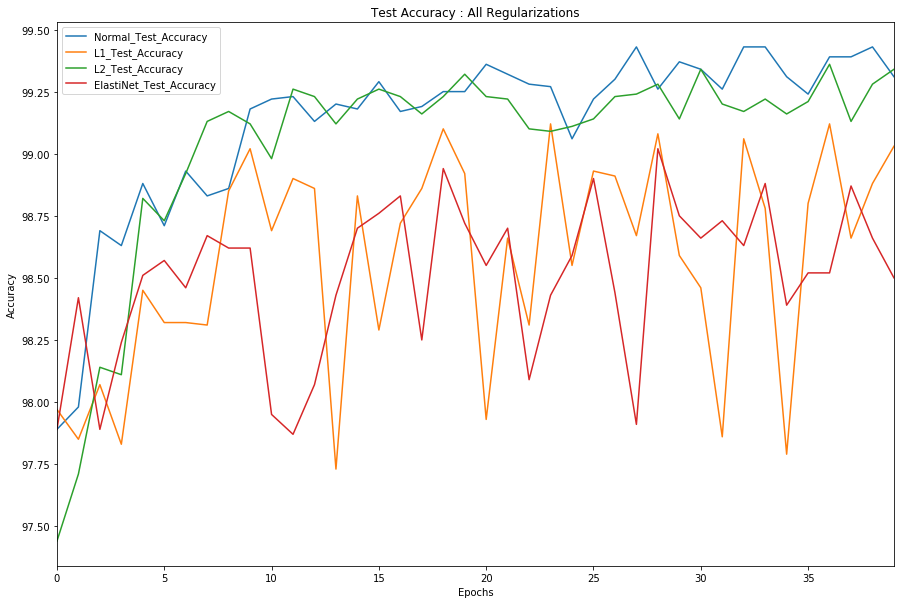

In [0]:
import pandas as pd
Testing_all_loss = pd.DataFrame({'Normal_Test_Loss' : test_losses,
                                 'L1_Test_Loss' : test_losses_l1,
                                 'L2_Test_Loss' : test_losses_l2,
                                 'ElastiNet_Test_Loss' : test_losses_l1_l2
                                 })

Testing_all_accuracy = pd.DataFrame({'Normal_Test_Accuracy' : test_acc,
                                     'L1_Test_Accuracy' : test_acc_l1,
                                     'L2_Test_Accuracy' : test_acc_l2,
                                     'ElastiNet_Test_Accuracy' : test_acc_l1_l2
                                     })

fig1 = Testing_all_loss.plot(figsize=(15,10),kind = 'line', title = "Test Loss : All Regularizations")
fig1.set_xlabel("Epochs")
fig1.set_ylabel("loss")
fig2 = Testing_all_accuracy.plot(figsize=(15,10),kind = 'line',title = "Test Accuracy : All Regularizations")
fig2.set_xlabel("Epochs")
fig2.set_ylabel("Accuracy")

fig1
fig2

L1 Vs L2 :

L1 offers feature selection and this is particulalrly efficient if coupled with early stopping criterion, could perform a bit better.  
L2 is definitely the winner as it does not eliminate any features, just minimises their importance.  

L1 accuracy looks highly unstable.  
L2 accuracy is pretty stable and keeps increasing.  

Perhaps this is the reason why pytorch gives L2 as default.  